## Network Definition

In [53]:
import sys
for path in sys.path:
    print(path)

/home/akiva/miniconda3/envs/ml_env/lib/python312.zip
/home/akiva/miniconda3/envs/ml_env/lib/python3.12
/home/akiva/miniconda3/envs/ml_env/lib/python3.12/lib-dynload

/home/akiva/miniconda3/envs/ml_env/lib/python3.12/site-packages
/home/akiva/FCNX-Ensembling/lib/
/home/akiva/FCNX-Ensembling/lib/
/home/akiva/FCNX-Ensembling/lib/
/home/akiva/FCNX-Ensembling/lib/
/home/akiva/FCNX-Ensembling/lib/
/home/akiva/FCNX-Ensembling/lib/


In [54]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('/home/akiva/FCNX-Ensembling/lib/')
from FCN2VALID import *


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [55]:
print("Hello, World!")

Hello, World!


## Training


Testing N=40
Avg Kernel Discrepancy erf-arcsin for N =  40 0.005466037895530462
Avg Kernel Discrepancy linear-dot for N =  40 0.013445784337818623

Testing N=100
Avg Kernel Discrepancy erf-arcsin for N =  100 0.002933490788564086
Avg Kernel Discrepancy linear-dot for N =  100 0.007697653025388718

Testing N=200
Avg Kernel Discrepancy erf-arcsin for N =  200 0.002725197235122323
Avg Kernel Discrepancy linear-dot for N =  200 0.005419903434813023

Testing N=400
Avg Kernel Discrepancy erf-arcsin for N =  400 0.0016517341136932373
Avg Kernel Discrepancy linear-dot for N =  400 0.0037422478199005127

Testing N=800
Avg Kernel Discrepancy erf-arcsin for N =  800 0.0012612435966730118
Avg Kernel Discrepancy linear-dot for N =  800 0.0027760316152125597

Testing N=1600
Avg Kernel Discrepancy erf-arcsin for N =  1600 0.0008094843360595405
Avg Kernel Discrepancy linear-dot for N =  1600 0.0016646672738716006

Testing N=3200
Avg Kernel Discrepancy erf-arcsin for N =  3200 0.0005513183423317969
Av

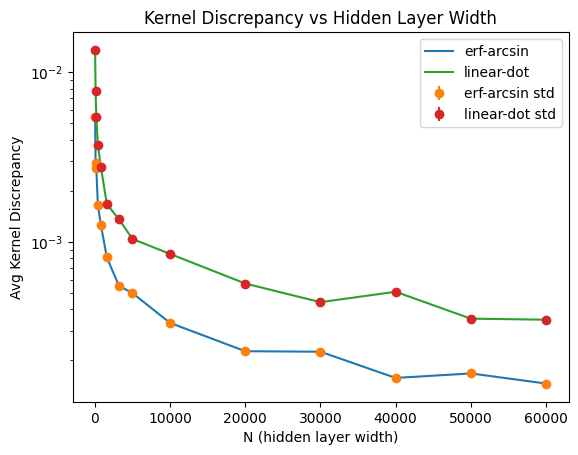

In [56]:
d = 10
Ns = [40, 100, 200, 400, 800, 1600, 3200, 5000, 10000, 20000, 30000, 40000, 50000, 60000]
P = 40
ens = 100
device = torch.device("cuda:1")
SEED = 42
EPOCHS = 1.0
RIDGE = 1.0
TEMPERATURE = 2.0 * RIDGE
torch.manual_seed(SEED)
X = torch.randn(P, d, device=device)
Y = X[:, 0].unsqueeze(1)

kernel_erf_discrepancies = []
kernel_erf_discrepancies_std = []
kernel_linear_discrepancies = []
kernel_linear_discrepancies_std = []
for i in Ns:
    N = i
    print(f"\nTesting N={N}")
    model_linear = FCN2NetworkActivationGeneric(
        d, N, P, ens=ens,
        activation="linear",
        weight_initialization_variance=(1/d, 1/N)
    ).to(device)
    model_erf = FCN2NetworkActivationGeneric(
        d, N, P, ens=ens,
        activation="erf",
        weight_initialization_variance=(1/d, 1/N)
    ).to(device)

    # Comparing network's kernel at initialization to theoretical NNGP kernel
    H_kernel_linear_init = model_linear.H_Kernel(X)
    H_kernel_erf_init = model_erf.H_Kernel(X)
    H_erf_arcsin = arcsin_kernel(X)
    print("Avg Kernel Discrepancy erf-arcsin for N = ", N, torch.mean(torch.abs(H_kernel_erf_init - H_erf_arcsin)).item())
    print("Avg Kernel Discrepancy linear-dot for N = ", N, torch.mean(torch.abs(H_kernel_linear_init - linear_dot_kernel(X))).item())
    kernel_erf_discrepancies.append(torch.mean(torch.abs(H_kernel_erf_init - H_erf_arcsin)).item())
    kernel_linear_discrepancies.append(torch.mean(torch.abs(H_kernel_linear_init - linear_dot_kernel(X))).item())
    kernel_erf_discrepancies_std.append(torch.abs(H_kernel_erf_init - H_erf_arcsin).std().item() / torch.sqrt(torch.tensor(P * P)))
    kernel_linear_discrepancies_std.append(torch.abs(H_kernel_linear_init - linear_dot_kernel(X)).std().item() / torch.sqrt(torch.tensor(P * P)))
    del H_kernel_linear_init, H_kernel_erf_init, H_erf_arcsin, model_linear, model_erf
plt.figure()
plt.plot(Ns, kernel_erf_discrepancies, label='erf-arcsin')
plt.errorbar(Ns, kernel_erf_discrepancies, yerr=kernel_erf_discrepancies_std, fmt='o', label='erf-arcsin std')
plt.plot(Ns, kernel_linear_discrepancies, label='linear-dot')
plt.errorbar(Ns, kernel_linear_discrepancies, yerr=kernel_linear_discrepancies_std, fmt='o', label='linear-dot std')
plt.yscale('log')
plt.xlabel('N (hidden layer width)')
plt.ylabel('Avg Kernel Discrepancy')
plt.title('Kernel Discrepancy vs Hidden Layer Width')
plt.legend()
plt.show()



In [57]:
SEED = 42
P = 20
d = 3
device = torch.device("cuda:1")

LOG_INTERVAL = 1000
EPOCHS = 200_000
RIDGE = 1.0
TEMPERATURE = 2.0 * RIDGE
ens = 100
torch.manual_seed(SEED)
X = torch.randn(P, d, device=device)
Y = X[:, 0].unsqueeze(1)
N = 2048
chi = 1.0
model_erf = FCN2NetworkActivationGeneric(
    d, N, P, ens=ens,
    activation="erf",
    weight_initialization_variance=(1/d, 1/(N))
).to(device)

model_linear = FCN2NetworkActivationGeneric(
    d, N, P, ens=ens,
    activation="linear",
    weight_initialization_variance=(1/d, 1/(N))
).to(device)
losses_erf, losses_std_erf, As_erf, Ws_erf, eigs = train_fcn2(X, Y, model_erf, chi = chi, epochs=EPOCHS, log_interval=LOG_INTERVAL,lr0=1e-5, temperature=TEMPERATURE)
# losses_linear, losses_std_linear, As_linear, Ws_linear, eigs = train_fcn2(X, Y, model_linear, chi = chi, epochs=EPOCHS, log_interval=LOG_INTERVAL,lr0=1e-6, temperature=TEMPERATURE)


Initial loss
Epoch 0 logging:
Epoch 0: loss=2.607635e+01±1.527599e+01


Epoch 1000 logging:
Epoch 1000: loss=4.332507e+00±2.521400e+00
Epoch 2000 logging:
Epoch 2000: loss=3.966804e+00±2.379263e+00
Epoch 3000 logging:
Epoch 3000: loss=4.180178e+00±2.460981e+00
Epoch 4000 logging:
Epoch 4000: loss=4.290524e+00±2.490151e+00
Epoch 5000 logging:
Epoch 5000: loss=4.641484e+00±2.912722e+00
Epoch 6000 logging:
Epoch 6000: loss=4.329122e+00±2.820804e+00
Epoch 7000 logging:
Epoch 7000: loss=4.351893e+00±2.808112e+00
Epoch 8000 logging:
Epoch 8000: loss=4.386973e+00±2.529583e+00
Epoch 9000 logging:
Epoch 9000: loss=4.877018e+00±2.743262e+00
Epoch 10000 logging:
Epoch 10000: loss=4.679248e+00±2.900689e+00
Epoch 11000 logging:
Epoch 11000: loss=4.776329e+00±3.103911e+00
Epoch 12000 logging:
Epoch 12000: loss=4.436889e+00±2.710305e+00
Epoch 13000 logging:
Epoch 13000: loss=4.369410e+00±2.544259e+00
Epoch 14000 logging:
Epoch 14000: loss=4.444610e+00±2.509986e+00
Epoch 15000 logging:
Epoch 15000: loss=4.154791e+00±2.425454e+00
Epoch 16000 logging:
Epoch 16000: loss=4.37

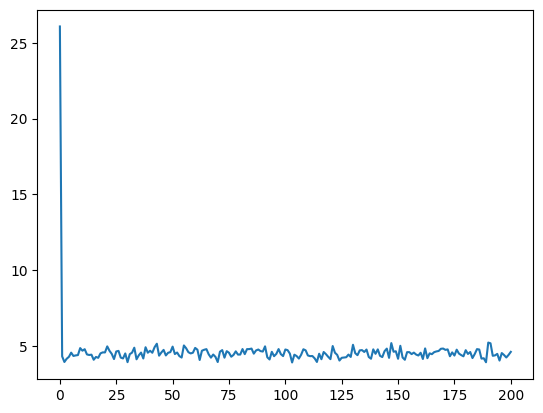

In [58]:
plt.plot(losses_erf, label='erf')

In [ ]:
pl

0.05

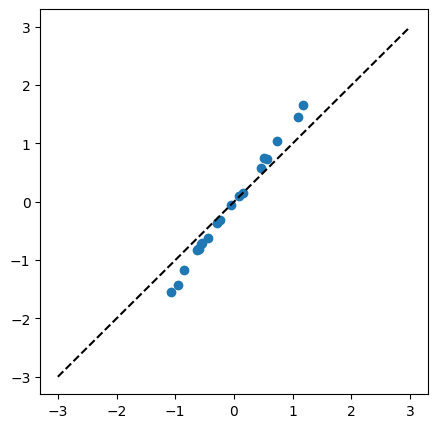

In [51]:
# Networks as well as gpr against true function 
plt.figure(figsize=(5,5))
gpr_arcsin_output = gpr(arcsin_kernel, X, Y[:,0], sigma0_sq=RIDGE )
plt.plot([-3,3], [-3,3], 'k--')
plt.scatter(gpr_arcsin_output.cpu().numpy(), model_erf.forward(X)[:,:].detach().cpu().numpy().mean(axis = 1),label='GPR Arcsin Kernel', marker='o')


In [29]:
X = torch.randn(5000, d, device=device)    
model_erf.H_eig(X,X).mean(), model_erf.H_eig(X,X).std()

(tensor(0.1211, device='cuda:1'), tensor(0.0020, device='cuda:1'))

In [10]:
LOG_INTERVAL = 1000

As_avg_linear = np.mean(np.array(As_linear), axis=2)
Ws_avg_linear = np.mean(np.array(Ws_linear), axis=2)
plt.figure()
plt.plot(As_avg_linear[:,:].mean(axis=1), label='A[0] mean over neurons')
plt.title('Output Weights W over Training')
plt.xlabel('Log Intervals')
plt.ylabel('A values')
plt.show()

As_avg_erf = np.mean(np.array(As_erf), axis=2)
Ws_avg_erf = np.mean(np.array(Ws_erf), axis=2)
plt.figure()
plt.plot(As_avg_erf[:,:].mean(axis=1), label='A[0] mean over neurons')
plt.title('Output Weights A over Training')
plt.xlabel('Log Intervals')
plt.ylabel('A values')
plt.show()

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(losses_linear, label='Linear Activation')
ax.fill_between(range(len(losses_linear)),
                np.array(losses_linear) - np.array(losses_std_linear),
                np.array(losses_linear) + np.array(losses_std_linear),
                alpha=0.3)
ax.plot(losses_erf, label='Erf Activation')
ax.fill_between(range(len(losses_erf)),
                np.array(losses_erf) - np.array(losses_std_erf),
                np.array(losses_erf) + np.array(losses_std_erf),
                alpha=0.3)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('Epoch') 
ax.set_ylabel('SSE Loss')
ax.set_title('Training Loss Comparison: Linear vs Erf Activation')
ax.legend()
plt.show()

def model_erf_kernel(X):
    return model_erf.H_Kernel(X)
def model_linear_kernel(X):
    return model_linear.H_Kernel(X)
gpr_arcsin_output = gpr(arcsin_kernel, X, Y[:,0], sigma0_sq=RIDGE)
gpr_linear_output = gpr(linear_dot_kernel, X, Y[:,0], sigma0_sq=RIDGE)
gpr_nngp_linear_output = gpr(model_linear_kernel, X, Y[:,0], sigma0_sq=RIDGE)
gpr_nngp_erf_output = gpr(model_erf_kernel, X, Y[:,0], sigma0_sq=RIDGE)
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].scatter(gpr_arcsin_output.cpu().numpy(), gpr_nngp_erf_output.cpu().numpy())
ax[0].set_title("Arcsin Kernel GPR vs FCN2 Erf")
ax[0].set_xlabel("GPR Output")
ax[0].set_ylabel("FCN2 Output")
ax[0].plot([-3,3], [-3,3], 'k--')
ax[1].scatter(gpr_linear_output.cpu().numpy(), gpr_nngp_linear_output.cpu().numpy())
ax[1].set_title("Linear Dot Product Kernel GPR vs FCN2 Linear")
ax[1].set_xlabel("GPR Output")
ax[1].set_ylabel("FCN2 Output")
ax[1].plot([-3,3], [-3,3], 'k--')
plt.show()


NameError: name 'As_linear' is not defined

In [ ]:
# Save models
torch.save(model_linear.state_dict(), f"fcn2_linear_d{d}_P{P}_N{N}_ens{ens}_ridge{RIDGE}_epochs{EPOCHS}.pt")
torch.save(model_erf.state_dict(), f"fcn2_erf_d{d}_P{P}_N{N}_ens{ens}_ridge{RIDGE}_epochs{EPOCHS}.pt")  

In [ ]:
As_avg_[:,:].shape

(101, 100)

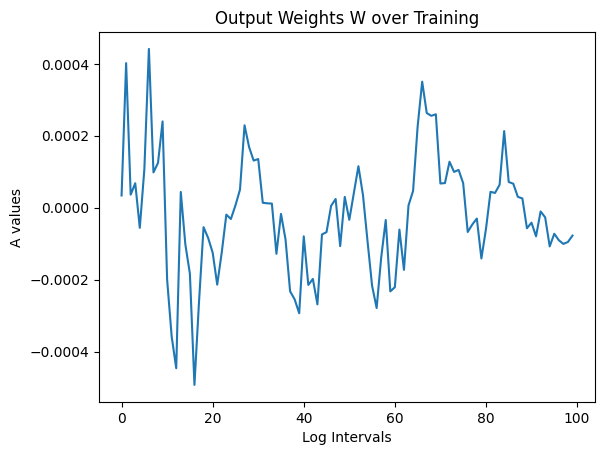

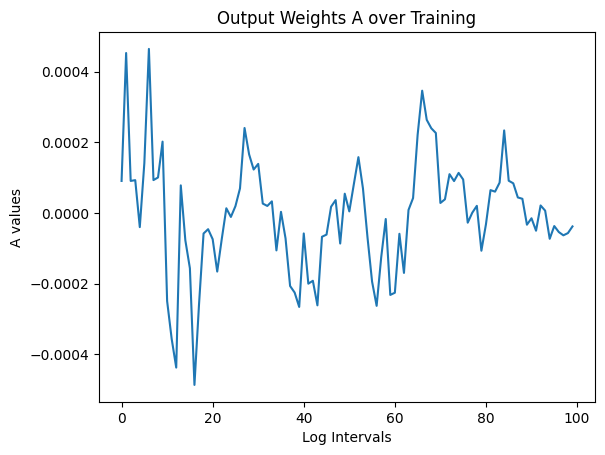

In [ ]:
As_avg_linear = np.mean(np.array(As_linear), axis=2)
Ws_avg_linear = np.mean(np.array(Ws_linear), axis=2)
plt.figure()
plt.plot(As_avg_linear[:,:].mean(axis=1), label='A[0] mean over neurons')
plt.title('Output Weights W over Training')
plt.xlabel('Log Intervals')
plt.ylabel('A values')
plt.show()

As_avg_erf = np.mean(np.array(As_erf), axis=2)
Ws_avg_erf = np.mean(np.array(Ws_erf), axis=2)
plt.figure()
plt.plot(As_avg_erf[:,:].mean(axis=1), label='A[0] mean over neurons')
plt.title('Output Weights A over Training')
plt.xlabel('Log Intervals')
plt.ylabel('A values')
plt.show()

In [ ]:
losses_std

tensor([1.7906, 0.4717, 0.4604, 0.4070, 0.4514, 0.4121, 0.4300, 0.4759, 0.4520,
        0.3492, 0.4310, 0.3988, 0.4336, 0.4359, 0.3598, 0.4313, 0.4554, 0.4539,
        0.3994, 0.4244, 0.4397, 0.4187, 0.4651, 0.4265, 0.4172, 0.4590, 0.4068,
        0.4416, 0.4268, 0.3972, 0.4038, 0.4822, 0.3878, 0.4390, 0.4033, 0.4288,
        0.4796, 0.4500, 0.4339, 0.4705, 0.4179, 0.4334, 0.4442, 0.5415, 0.4877,
        0.4901, 0.4210, 0.4719, 0.4459, 0.4385, 0.4491, 0.4539, 0.4665, 0.4762,
        0.4294, 0.4067, 0.4531, 0.4146, 0.4391, 0.4319, 0.4382, 0.4517, 0.4751,
        0.4722, 0.4503, 0.4265, 0.4801, 0.4222, 0.4546, 0.3978, 0.4407, 0.4067,
        0.3963, 0.4613, 0.4659, 0.4596, 0.4606, 0.4056, 0.4465, 0.4500, 0.4320,
        0.3638, 0.3551, 0.4640, 0.4155, 0.4313, 0.4342, 0.4488, 0.4538, 0.3975,
        0.4178, 0.4419, 0.4277, 0.4368, 0.4318, 0.3908, 0.4096, 0.4092, 0.3950,
        0.4123, 0.4249])

/tmp/ipykernel_3182377/3534632781.py:4: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  np.array(losses_linear) - np.array(losses_std_linear),
/tmp/ipykernel_3182377/3534632781.py:5: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  np.array(losses_linear) + np.array(losses_std_linear),
/tmp/ipykernel_3182377/3534632781.py:9: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keywor

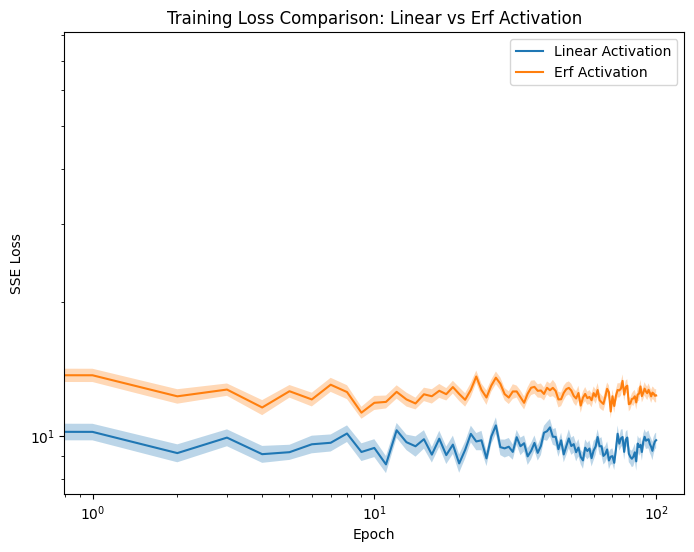

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(losses_linear, label='Linear Activation')
ax.fill_between(range(len(losses_linear)),
                np.array(losses_linear) - np.array(losses_std_linear),
                np.array(losses_linear) + np.array(losses_std_linear),
                alpha=0.3)
ax.plot(losses_erf, label='Erf Activation')
ax.fill_between(range(len(losses_erf)),
                np.array(losses_erf) - np.array(losses_std_erf),
                np.array(losses_erf) + np.array(losses_std_erf),
                alpha=0.3)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('Epoch') 
ax.set_ylabel('SSE Loss')
ax.set_title('Training Loss Comparison: Linear vs Erf Activation')
ax.legend()
plt.show()

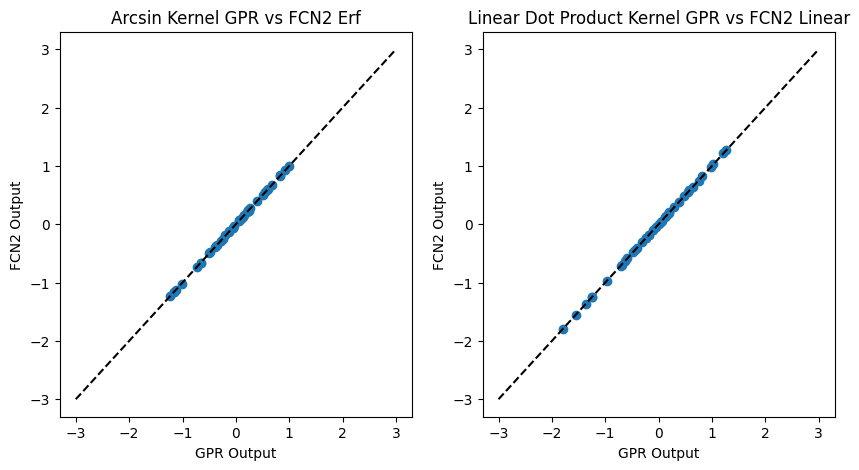

In [13]:
def model_erf_kernel(X):
    return model_erf.H_Kernel(X)
def model_linear_kernel(X):
    return model_linear.H_Kernel(X)
gpr_arcsin_output = gpr(arcsin_kernel, X, Y[:,0], sigma0_sq=RIDGE)
gpr_linear_output = gpr(linear_dot_kernel, X, Y[:,0], sigma0_sq=RIDGE)
gpr_nngp_linear_output = gpr(model_linear_kernel, X, Y[:,0], sigma0_sq=RIDGE)
gpr_nngp_erf_output = gpr(model_erf_kernel, X, Y[:,0], sigma0_sq=RIDGE)
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].scatter(gpr_arcsin_output.cpu().numpy(), gpr_nngp_erf_output.cpu().numpy())
ax[0].set_title("Arcsin Kernel GPR vs FCN2 Erf")
ax[0].set_xlabel("GPR Output")
ax[0].set_ylabel("FCN2 Output")
ax[0].plot([-3,3], [-3,3], 'k--')
ax[1].scatter(gpr_linear_output.cpu().numpy(), gpr_nngp_linear_output.cpu().numpy())
ax[1].set_title("Linear Dot Product Kernel GPR vs FCN2 Linear")
ax[1].set_xlabel("GPR Output")
ax[1].set_ylabel("FCN2 Output")
ax[1].plot([-3,3], [-3,3], 'k--')
plt.show()


In [ ]:
model_erf.forward(X).shape

torch.Size([40, 100])

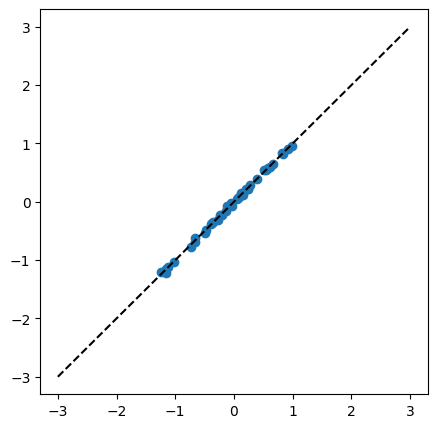

In [14]:
# Networks as well as gpr against true function 
plt.figure(figsize=(5,5))
# --- IGNORE ---
plt.plot([-3,3], [-3,3], 'k--')
plt.scatter(gpr_arcsin_output.cpu().numpy(), model_erf.forward(X)[:,:].detach().cpu().numpy().mean(axis = 1),label='GPR Arcsin Kernel', marker='o')

# plt.figure(figsize=(5,5))
# plt.plot([-3,3], [-3,3], 'k--')
# plt.scatter(gpr_linear_output.cpu().numpy(), model_linear.forward(X)[:,:].detach().cpu().numpy().mean(axis = 1), label='GPR Linear Kernel', marker='s')

# Testing Dataset Averaged Networks



In [ ]:
import sys

%load_ext autoreload
%autoreload 2
sys.path.append('/home/akiva/FCNX-Ensembling/lib')
from DataAveragedNetworks import *
from FCN2VALID import *
Ds = 6
Q = 100
d = 30
N = 400
P = 90
device = torch.device("cuda:0")
model_erf_da = FCN2NetworkDataAveragedEnsemble(
    d, N, P, num_ensembles = Q, num_datasets = Ds,
    activation="erf",
    weight_initialization_variance=(1/d, 1/(N))
).to(device)
model_erf_da.device = device

X = torch.randn(Ds, P, d, device=device)
Y = X[:,:, 0].unsqueeze(2)


losses_erf_da, losses_std_erf_da, As_erf_da, Ws_erf_da, eigs_da = train_fcn2_dataset_averaged(X, Y, model_erf_da, chi = 1.0, epochs=100_000, log_interval=100,lr0=1e-6, temperature=2.0)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Initial loss
Output shape: torch.Size([6, 90, 100])
torch.Size([6, 90, 100])
Output shape: torch.Size([6, 90, 100])
torch.Size([6, 90, 100])
Epoch 0: loss=8.403871e+02±4.978065e+00
Epoch 100: loss=6.325815e+02±3.755837e+00
Epoch 200: loss=5.029800e+02±3.001819e+00
Epoch 300: loss=4.170716e+02±2.498089e+00
Epoch 400: loss=3.615009e+02±2.163947e+00
Epoch 500: loss=3.255954e+02±1.954120e+00
Epoch 600: loss=2.999620e+02±1.829442e+00
Epoch 700: loss=2.801255e+02±1.713805e+00
Epoch 800: loss=2.618603e+02±1.608568e+00
Epoch 900: loss=2.517546e+02±1.554399e+00
Epoch 1000: loss=2.408630e+02±1.488801e+00
Epoch 1100: loss=2.333610e+02±1.438279e+00
Epoch 1200: loss=2.291539e+02±1.424821e+00
Epoch 1300: loss=2.258412e+02±1.418547e+00
Epoch 1400: loss=2.233485e+02±1.410104e+00
Epoch 1500: loss=2.206372e+02±1.383176e+00
Epoch 1600: loss=2.181832e+02±1.377315e+00
Epoch 1700: loss=2.159575e+02±1.359142e+00
Epoch 180

In [ ]:
model_erf_da.forward(X).shape

torch.Size([6, 90, 4])

In [12]:
gpr_arcsin_output = torch.zeros((Ds, P), device=device)
for i in range(Ds):
    gpr_arcsin_output[i] = gpr(arcsin_kernel, X[i], Y[i,:,0], sigma0_sq=1.0)
gpr_arcsin_output = gpr_arcsin_output.mean(dim=0)

NameError: name 'Ds' is not defined

In [ ]:
gpr_arcsin_output.shape

torch.Size([6, 90])

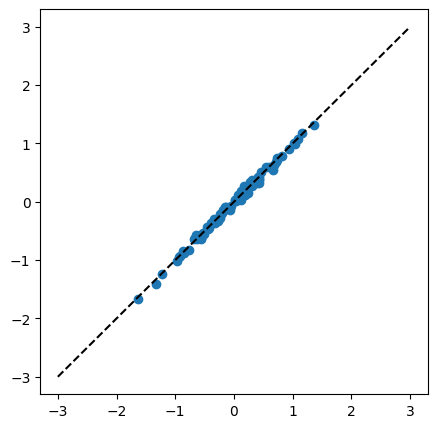

In [ ]:
# Networks as well as gpr against true function 
plt.figure(figsize=(5,5))
# --- IGNORE ---
plt.plot([-3,3], [-3,3], 'k--')
for i in [0]:
    out = model_erf_da.forward(X)[i].mean(axis = 1).detach().cpu().numpy()
    err = model_erf_da.forward(X)[i].std(axis = 1).detach().cpu().numpy() / np.sqrt(Q)
    plt.scatter(gpr_arcsin_output[i].cpu().numpy(), out,label='GPR Arcsin Kernel')


In [ ]:
model_erf_da.H_eig_data_averaged(Xinf, Xinf,std=True)

(tensor([1.9087, 1.8313, 1.8822, 1.8952, 1.8678, 1.8891, 1.8865, 1.8940, 1.8706,
         1.9363, 1.8765, 1.8598, 1.8806, 1.9007, 1.8879, 1.8205, 1.9189, 1.8643,
         1.9395, 1.9001, 1.9398, 1.8948, 1.8752, 1.8559, 1.8093, 1.8643, 1.8883,
         1.8772, 1.9083, 1.8259], device='cuda:0'),
 tensor([0.0835, 0.0920, 0.1344, 0.1060, 0.0881, 0.0792, 0.0790, 0.1247, 0.1029,
         0.0604, 0.0812, 0.1034, 0.0962, 0.0485, 0.1432, 0.1150, 0.1206, 0.0900,
         0.1371, 0.1158, 0.1141, 0.1088, 0.1002, 0.1058, 0.0918, 0.1032, 0.1064,
         0.1082, 0.0898, 0.1016], device='cuda:0'))

In [ ]:
Y.squeeze().shape

torch.Size([6, 30])

## Moving to MEAN FIELD Scaling

In [ ]:
EPOCHS = 40_000_000
RIDGE = 1.0
TEMPERATURE = 2.0 * RIDGE
ens = 100
SEED = 42
d = 30
P = 12000
device = torch.device("cuda:1")
torch.manual_seed(SEED)
X = torch.randn(P, d, device=device)
Y = X[:, 0].unsqueeze(1)
N = 512
chi = 512
model_erf = FCN2NetworkActivationGeneric(
    d, N, P, ens=ens,
    activation="erf",
    weight_initialization_variance=(1/d, 1/(N))
).to(device)
LOG_INTERVAL = 10000


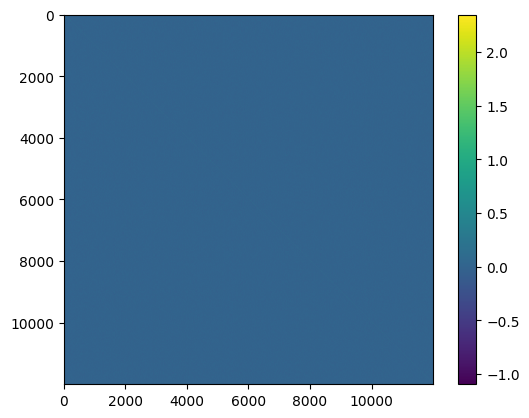

In [ ]:
import matplotlib.pyplot as plt
plt.imshow((X @ X.T).cpu().numpy() / d)
plt.colorbar()
plt.show()

In [ ]:

model_save_dir = f"./checkpoints_fcn2_erf_d{d}_P{P}_N{N}_ens{ens}_ridge{RIDGE}_epochs{EPOCHS}/"
Path(model_save_dir).mkdir(parents=True, exist_ok=True)

tensorboard_writer = SummaryWriter(log_dir=f'./tensorboard_logs/fcn2_erf_d{d}_P{P}_N{N}_ens{ens}_ridge{RIDGE}_epochs{EPOCHS}/')
losses_erf, losses_std_erf, As_erf, Ws_erf = train_fcn2(X, Y, model_erf, chi = chi, epochs=EPOCHS, log_interval=LOG_INTERVAL,lr0=1e-6, temperature=TEMPERATURE, save_to=model_save_dir, tensorboard_writer=tensorboard_writer)

Initial loss
Epoch 0: loss=1.734694e+04±3.342816e+03
Epoch 10000: loss=1.131035e+02±2.539772e+00
Epoch 20000: loss=1.017371e+02±2.053352e+00
Epoch 30000: loss=9.479262e+01±1.870789e+00
Epoch 40000: loss=8.998133e+01±1.696474e+00
Epoch 50000: loss=8.631236e+01±1.570748e+00


KeyboardInterrupt: 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def run_experiment(train_results, model_erf, chi):
    """Trains linear and erf models with specific chi and generates diagnostic plots."""

    # 1. Training
    results = {}
    for name, model in [("Erf", model_erf)]:
        loss, loss_std, As, Ws, eigs = train_results
        results[name] = {"loss": loss, "std": loss_std, "As": np.array(As), "Ws": np.array(Ws), "eigs": np.array(eigs), "model": model}
    # 2. Plot Weight Evolution (A and W)
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    for i, (name, data) in enumerate(results.items()):
        A_mean = np.mean(data["As"], axis=2).mean(axis=1)
        axes[i].plot(A_mean, label=f'Mean A ({name})')
        axes[i].set_title(f'{name} Output Weights ($\chi={chi}$)')
        axes[i].set_xlabel('Log Intervals')
        axes[i].set_ylabel('Weight Value')
        axes[i].legend()
    plt.show()

    #2b Plotting eigenvalues over time
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    for i, (name, data) in enumerate(results.items()):
        eigs = data["eigs"]  # List of (num_eigenvalues, 2) arrays
        if len(eigs) == 0:
            continue
        eigs_array = np.array(eigs)  # Shape: (num_logs, num_eigenvalues, 2)
        mean_eigs = eigs_array[:, :, 0]  # Mean eigenvalues over time
        for j in range(min(5, mean_eigs.shape[1])):  # Plot first 5 eigenvalues
            # Plot largest eig
            axes[i].plot(mean_eigs[:,:].max(axis=1), label=f'Largest Eigenvalue')
            axes[i].plot(mean_eigs[:, j], label=f'Eigenvalue {j+1}')
        axes[i].set_title(f'{name} Leading Eigenvalues Over Time ($\chi={chi}$)')
        axes[i].set_xlabel('Log Intervals')
        axes[i].set_ylabel('Eigenvalue')
        axes[i].legend()
    plt.show()

    # 3. Training Loss Comparison
    plt.figure(figsize=(8, 6))
    for name, data in results.items():
        epochs_range = range(len(data["loss"]))
        plt.plot(epochs_range, data["loss"], label=f'{name} Activation')
        plt.fill_between(epochs_range, 
                         np.array(data["loss"]) - np.array(data["std"]),
                         np.array(data["loss"]) + np.array(data["std"]), alpha=0.2)
    
    plt.yscale('log'); plt.xscale('log')
    plt.title(f'Training Loss Comparison ($\chi={chi}$)')
    plt.xlabel('Epoch'); plt.ylabel('SSE Loss'); plt.legend()
    plt.show()

    # # 4. GPR vs FCN Kernel Comparison
    # gpr_configs = [
    #     (arcsin_kernel, results["Erf"]["model"].H_Kernel, "Arcsin vs Erf"),
    #     (linear_dot_kernel, results["Linear"]["model"].H_Kernel, "Linear vs Linear")
    # ]
    
    # fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    # for i, (k_func, m_kernel, title) in enumerate(gpr_configs):
    #     out_gpr = gpr(k_func, X, Y[:, 0], sigma0_sq=ridge).cpu().numpy()
    #     out_fcn = gpr(m_kernel, X, Y[:, 0], sigma0_sq=ridge).cpu().numpy()
        
    #     ax[i].scatter(out_gpr, out_fcn, alpha=0.5)
    #     ax[i].plot([-3, 3], [-3, 3], 'k--')
    #     ax[i].set_title(f"{title} ($\chi={chi}$)")
    #     ax[i].set_xlabel("GPR Output"); ax[i].set_ylabel("FCN2 Output")
    # plt.tight_layout()
    # plt.show()



import numpy as np
import multiprocess as mp # Use 'multiprocess', not 'multiprocessing'

# 1. Configuration (defined globally in the cell)

def worker_task(i):
    import torch
    import numpy as np
    import sys
    sys.path.append('/home/akiva/FCNX-Ensembling/journal')
    from FCN2NNGP import train_fcn2, FCN2NetworkActivationGeneric, FCN2NetworkEnsembleErf, FCN2NetworkEnsembleLinear
    """The function each process will execute."""
    seeds = [176, 231, 297, 385, 490]
    d = 150
    P = 600
    device = torch.device("cuda:1")
    SEED = seeds[i]
    EPOCHS = 5_000_000
    LOG_INTERVAL = 15000
    RIDGE = 1.0
    TEMPERATURE = 2.0 * RIDGE
    ens = 5
    torch.manual_seed(SEED)
    X = torch.randn(P, d, device=device)
    Y = X[:, 0].unsqueeze(1)
    N = 700
    chi = N // 4


    # Each process needs its own device context
    worker_device = f"cuda:0"
    
    # Calculate P and kappa
    # p_values = np.logspace(np.log10(40), np.log10(400), len(seeds))
    # p_val = p_values[i]
    # kappa_val = p_val / 100
    # P_int = int(p_val)
    
    seed = seeds[i]
    torch.manual_seed(seed)
    
    # Data & Model Setup
    X = torch.randn(P, d, device=worker_device)
    Y = X[:, 0].unsqueeze(1)
    
    model = FCN2NetworkActivationGeneric(
        d, N, P, ens=ens,
        activation="erf",
        weight_initialization_variance=(1/d, 1/(N * chi))
    ).to(worker_device)
    model.device = worker_device
    # Training
    losses, losses_std, _, _, eigs = train_fcn2(
        X, Y, model, chi=N, 
        log_interval=LOG_INTERVAL,
        epochs=EPOCHS, lr0=3e-6, temperature=TEMPERATURE, save_weights=False
    )
    torch.save(model.state_dict(), f"fcn2_erf_d{d}_P{P}_N{N}_ens{ens}_kappa{chi}_ridge{RIDGE}_epochs{EPOCHS}_seed{seed}.pt")
    # Return serializable data (move tensors to CPU)
    return {"P":P, "kappa": chi,"d": d, "seed": seed, "P": P, "losess": losses, "losses_std": losses_std, "model": model, "eigs": eigs}
    # return {"P":P, "kappa": kappa_val,"d": d, "seed": seed, "P": P_int, "losess": losses, "losses_std": losses_std, "As": As, "Ws": Ws, "eigs": eigs}
ctx = mp.get_context('spawn')
num_workers = 4

seeds = [176, 231, 297, 385, 490]

# CRITICAL: Use ctx.Pool here
with ctx.Pool(num_workers) as pool:
    final_output = pool.map(worker_task, range(len(seeds)))

<>:17: SyntaxWarning: invalid escape sequence '\c'
<>:35: SyntaxWarning: invalid escape sequence '\c'
<>:51: SyntaxWarning: invalid escape sequence '\c'
<>:17: SyntaxWarning: invalid escape sequence '\c'
<>:35: SyntaxWarning: invalid escape sequence '\c'
<>:51: SyntaxWarning: invalid escape sequence '\c'
/tmp/ipykernel_3182377/1455147964.py:17: SyntaxWarning: invalid escape sequence '\c'
  axes[i].set_title(f'{name} Output Weights ($\chi={chi}$)')
/tmp/ipykernel_3182377/1455147964.py:35: SyntaxWarning: invalid escape sequence '\c'
  axes[i].set_title(f'{name} Leading Eigenvalues Over Time ($\chi={chi}$)')
/tmp/ipykernel_3182377/1455147964.py:51: SyntaxWarning: invalid escape sequence '\c'
  plt.title(f'Training Loss Comparison ($\chi={chi}$)')


In [ ]:
# Load up the stored models from 

NameError: name 'final_output' is not defined

In [ ]:
results_erf = train_fcn2(X, Y, model_erf, chi = chi, epochs=3000000, log_interval=LOG_INTERVAL,lr0=1e-5, temperature=TEMPERATURE)


Initial loss
  loss=1.498436e+00±1.989640e-01
Epoch 0: loss=1.498436e+00±1.989640e-01
Epoch 1000: loss=1.491098e+00±1.774042e-01
Epoch 2000: loss=1.470636e+00±2.024257e-01
Epoch 3000: loss=1.475839e+00±1.718304e-01
Epoch 4000: loss=1.488698e+00±1.811524e-01
Epoch 5000: loss=1.432952e+00±1.655544e-01
Epoch 6000: loss=1.480418e+00±1.831497e-01
Epoch 7000: loss=1.460052e+00±1.684821e-01
Epoch 8000: loss=1.484533e+00±2.180049e-01
Epoch 9000: loss=1.481997e+00±1.959208e-01
Epoch 10000: loss=1.465973e+00±1.971298e-01


KeyboardInterrupt: 

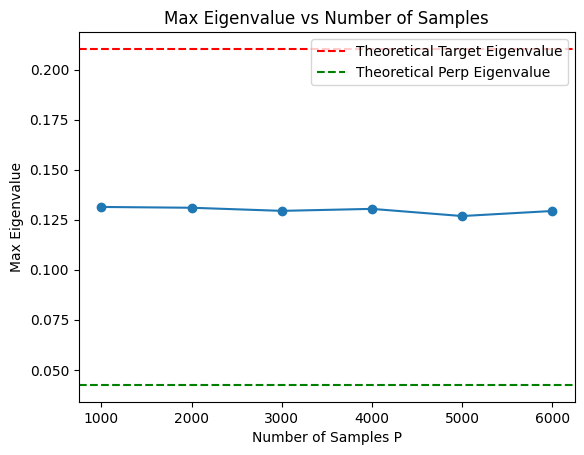

In [ ]:
max_eig = []
for p in [1000, 2000, 3000, 4000, 5000, 6000]:
    Xinf = torch.randn(3000, d, device=device)
    erf_eigs = model_erf.H_eig(Xinf, Xinf)
    max_eig.append(erf_eigs.max().item())
plt.figure()
plt.plot([1000, 2000, 3000, 4000, 5000, 6000], max_eig, marker='o')
plt.axhline(y=erf_theory['lJ'], color='r', linestyle='--', label='Theoretical Target Eigenvalue')
plt.axhline(y=erf_theory['lJP'], color='g', linestyle='--', label='Theoretical Perp Eigenvalue')
plt.xlabel('Number of Samples P')
plt.ylabel('Max Eigenvalue')
plt.title('Max Eigenvalue vs Number of Samples')
plt.legend()
plt.show()